# Simulated dynamics with initial conditions and parameters based on data

This notebook provides figures that show the *simulated dynamics* of the model using the initial conditions based on each of the data sets and parameters inferred from data (see `math_PhD.ipynb`,`parakeet.ipynb`, and `newcomb_frat.ipynb` for the figures related to the *inference*). 

In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.prep_data import *
from py.scores import *
from py.utils import *
# from SpringRank import SpringRank

from matplotlib import pyplot as plt  # use matplotlib version 3.2.2 or earlier
from matplotlib.ticker import MaxNLocator

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"
matplotlib.rcParams['mathtext.fontset'] = "dejavusans"

# Setup: 

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [3]:
@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

# Data Preparation

See `math_PhD.ipynb`,`parakeet.ipynb`, and `newcomb_frat.ipynb` for the full scripts.

In [4]:
# Math PhD
data_dir = 'data/PhD Exchange Network Data/'
T, labels, tsteps    = prep_math_phd(data_dir, top_n = 70) # T = sequence of 61 70x70 matrices for 1946-2006 
T, tsteps, A0, n_obs = initial_condition(T, tsteps, t_start = 14, t_end = 55) # aggregate all data <1960

# extract data for simulations
A0_math, n_math, n_rounds_math, m_math = A0, A0.shape[0], len(tsteps)-1, round(n_obs / (len(tsteps)-1))

# Parakeets (G1)
group    = 'G1'
data_dir = 'data/parakeet/'
T, tsteps, labels    = prep_parakeets(data_dir, group = group)
T, tsteps, A0, n_obs = initial_condition(T, tsteps, t_start = 0)

# extract data for simulations
A0_para1, n_para1, n_rounds_para1, m_para1 = A0, A0.shape[0], len(tsteps)-1, round(n_obs / (len(tsteps)-1))

# Parakeets (G2)
group    = 'G2'
data_dir = 'data/parakeet/'
T, tsteps, labels    = prep_parakeets(data_dir, group = group)
T, tsteps, A0, n_obs = initial_condition(T, tsteps, t_start = 0)

# extract data for simulations
A0_para2, n_para2, n_rounds_para2, m_para2 = A0, A0.shape[0], len(tsteps)-1, round(n_obs / (len(tsteps)-1))

# Newcomb Fraternity
rank_threshold = 5
data_dir       = 'data/newcomb_frat/'
T, tsteps, labels    = prep_newcomb_frat(data_dir, rank_threshold = rank_threshold)
T, tsteps, A0, n_obs = initial_condition(T, tsteps, t_start = 0)

# extract data for simulations
A0_newcomb, n_newcomb, n_rounds_newcomb, m_newcomb = A0, A0.shape[0], len(tsteps)-1, round(n_obs / (len(tsteps)-1))

# Simulation and Plotting

In [5]:
def dynamics_gridplot(BETA_1, BETA_2, LAMBDA, SCORE_FUNCTION, N, M_UPDATES, N_ROUNDS, AZERO, ymin=-0.00, ymax=0.2):
    # function to make a 2x2 figure with simulated trajectories based on the best-fit scenario
    
    np.random.seed(seed=6)

    fig, axarr = plt.subplots(2, 2, figsize = (8.0, 6.5))
    labels = ['(a) Math PhD: Root-Degree\n','(b) Parakeets (G1): SpringRank\n', \
              '(c) Parakeets (G2): SpringRank\n','(d) Newcomb Fraternity: SpringRank\n']

    for i in np.arange(len(BETA_1)):

        row_num = i % 2
        col_num = i // 2

        ax = axarr[row_num,col_num]
        n         = N[i]
        beta_1    = BETA_1[i]
        beta_2    = BETA_2[i]
        lam       = LAMBDA[i]
        m_updates = M_UPDATES[i]
        n_rounds  = N_ROUNDS[i]+1
        score_function = SCORE_FUNCTION[i]
        A0        = AZERO[i]

        M = model()
        M.set_score(score_function = score_function)
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta      = np.array([beta_1, beta_2]), 
                   lam       = lam, 
                   A0        = A0, 
                   n_rounds  = n_rounds, 
                   update    = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()

        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[:,k], color = "gray", alpha = .3) # cset_muted[k]
            
        top_trajectories = (GAMMA.mean(axis = 1).mean(axis = 0)).argsort()[::-1][0:8]
        k = 0
        for j in range(n):        
            if j in top_trajectories:
                ax.plot(GAMMA.mean(axis = 1)[:,j], color = cset_muted[k], alpha = 1, linewidth = 3)
                k += 1

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if (row_num == 0) and (col_num == 0): 
            ymax = 0.15
        else:
            ymax = 0.2
        ax.set(ylim = (ymin, ymax))
        ax.set(xlim = (0, np.int(n_rounds-1)))
        ax.tick_params()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))

        ax.set(xlabel = r'Time step ($t$)')
        ax.set(ylabel = r'Rank ($\gamma$)')

        title = str(labels[i]) + r'$\hat{\lambda} = $' + str(lam) \
                + r'$\;$,$\;$ $\hat{\beta}_1 = $' + str(round(beta_1,2)) \
                + r'$\;$,$\;$ $\hat{\beta}_2 = $' + str(round(beta_2,2))        
        ax.set_title( title )

        ax.yaxis.set_label_coords(-0.13,0.5)

    plt.tight_layout()
    return GAMMA

In [6]:
def dynamics_gridplot_all(BETA_1, BETA_2, LAMBDA, SCORE_FUNCTION, N, M_UPDATES, N_ROUNDS, AZERO, ymin=-0.0):
    # function to make a 4x3 figure with simulated trajectories based on all score functions
    
    np.random.seed(seed=6)

    fig, axarr = plt.subplots(4, 3, figsize = (12, 13))
    labels = ['(a) Math PhD: Root-Degree\n', '(b) Math PhD: PageRank\n', \
              '(c) Math PhD: SpringRank\n', '(d) Parakeets (G1): Root-Degree\n', \
              '(e) Parakeets (G1): PageRank\n', '(f) Parakeets (G1): SpringRank\n',\
              '(g) Parakeets (G2): Root-Degree\n', '(h) Parakeets (G2): PageRank\n', \
              '(i) Parakeets (G2): SpringRank\n', '(j) Newcomb Fraternity: Root-Degree\n', \
              '(k) Newcomb Fraternity: PageRank\n', '(l) Newcomb Fraternity: SpringRank\n']
    
    for i in np.arange(len(BETA_1)):

        row_num = i // 3
        col_num = i % 3

        ax = axarr[row_num,col_num]
        n         = N[i]
        beta_1    = BETA_1[i]
        beta_2    = BETA_2[i]
        lam       = LAMBDA[i]
        m_updates = M_UPDATES[i]
        n_rounds  = N_ROUNDS[i]+1
        score_function = SCORE_FUNCTION[i]
        A0        = AZERO[i]

        M = model()
        M.set_score(score_function = score_function)
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta      = np.array([beta_1, beta_2]), 
                   lam       = lam, 
                   A0        = A0, 
                   n_rounds  = n_rounds, 
                   update    = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()

        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[:,k], color = "gray", alpha = .3) # cset_muted[k]
            
#         top_trajectories = np.unique(GAMMA.mean(axis = 1).argmax(axis = 1))
        top_trajectories = (GAMMA.mean(axis = 1).mean(axis = 0)).argsort()[::-1][0:8]
        k = 0
        for j in range(n):        
            if j in top_trajectories:
                ax.plot(GAMMA.mean(axis = 1)[:,j], color = cset_muted[k], alpha = 1, linewidth = 3)
                k += 1

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if row_num == 0:
            ymax = 0.13
        else:
            ymax = 0.12 + (row_num + 1) * 0.04
        ax.set(ylim = (ymin, ymax))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=False))
        
        ax.set(xlim = (0, np.int(n_rounds-1)))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

        ax.set(xlabel = r'Time step ($t$)')
        ax.set(ylabel = r'Rank ($\gamma$)')

        title = str(labels[i]) + r'$\hat{\lambda} = $' + str(lam) \
                + r'$\;$,$\;$ $\hat{\beta}_1 = $' + str(round(beta_1,2)) \
                + r'$\;$,$\;$ $\hat{\beta}_2 = $' + str(round(beta_2,2))
        ax.set_title( title )

        ax.yaxis.set_label_coords(-0.16,0.5)

    plt.tight_layout()

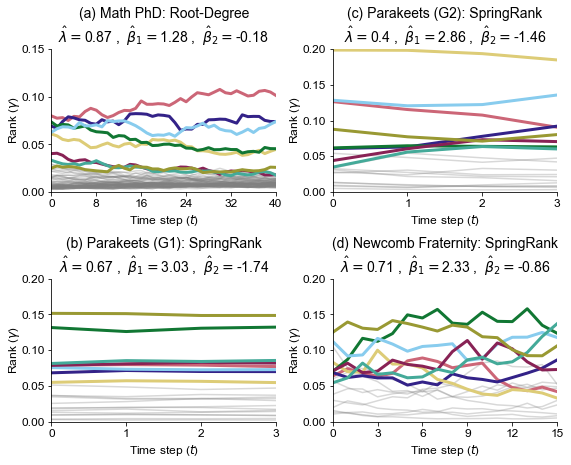

In [7]:
# Input parmaeters
# BETA_1, BETA_2, LAMBDA are the inferred values that give the best fit (see Table 4)
LAMBDA    = np.array([ 0.87,  0.67,  0.40,  0.71])
BETA_1    = np.array([ 1.28,  3.03,  2.86,  2.33])
BETA_2    = np.array([-0.18, -1.74, -1.46, -0.86])

# SCORE_FUNCTION lists the score funciton that gives the best fit above
SCORE_FUNCTION = [lambda A: powered_degree_score(A, 0.5)] + [lambda A: homebrew_SpringRank_score(A.T)] * 3

# N, M_UPDATES, N_ROUNDS, AZERO are extracted from the data
N         = np.array([n_math, n_para1, n_para2, n_newcomb]) # [70, 21, 19, 17]
M_UPDATES = np.array([m_math, m_para1, m_para2, m_newcomb]) # [150, 279, 320, 85]
N_ROUNDS  = np.array([n_rounds_math, n_rounds_para1, n_rounds_para2, n_rounds_newcomb]) # [40, 3, 3, 15]
AZERO     = [A0_math, A0_para1, A0_para2, A0_newcomb]

GAMMA = dynamics_gridplot(BETA_1, BETA_2, LAMBDA, SCORE_FUNCTION, N, M_UPDATES, N_ROUNDS, AZERO)
# plt.savefig('fig/dynamics_with_inferred_params.png', bbox_inches = 'tight', dpi = 600)
# plt.savefig('fig/dynamics_with_inferred_params.pdf', bbox_inches = 'tight', dpi = 600)

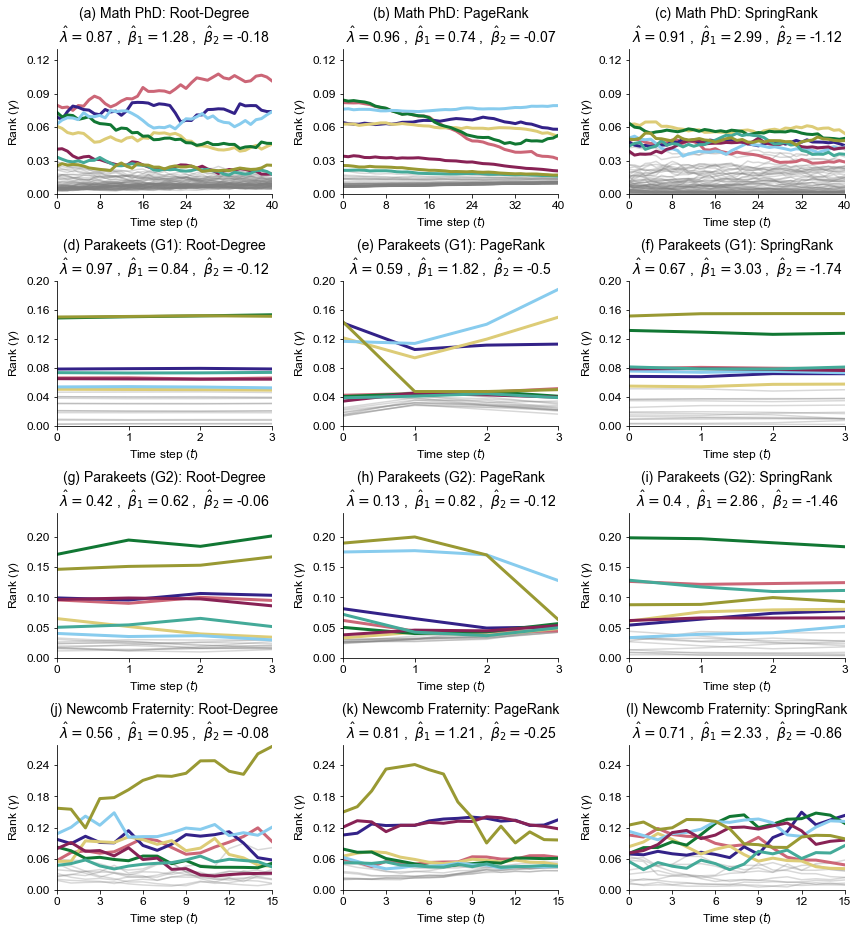

In [8]:
# Input parmaeters
# BETA_1, BETA_2, LAMBDA are the inferred values that give the best fit (see Table 4)
LAMBDA = np.array([ 0.87,  0.96,  0.91,  \
                    0.97,  0.59,  0.67,  \
                    0.42,  0.13,  0.40,  \
                    0.56,  0.81,  0.71])
BETA_1 = np.array([ 1.28,  0.74,  2.99,  \
                    0.84,  1.82,  3.03,  \
                    0.62,  0.82,  2.86,  \
                    0.95,  1.21,  2.33])
BETA_2 = np.array([-0.18, -0.07, -1.12,  \
                   -0.12, -0.50, -1.74,  \
                   -0.06, -0.12, -1.46,  \
                   -0.08, -0.25, -0.86])

# SCORE_FUNCTION lists the score funciton that gives the best fit above
SCORE_FUNCTION = [lambda A: powered_degree_score(A, 0.5),  \
                  lambda A: A.shape[0] * PageRank_score(A + 10**(-10)), \
                  lambda A: homebrew_SpringRank_score(A.T)] * 12

# N, M_UPDATES, N_ROUNDS, AZERO are extracted from the data
N         = np.array([n_math]*3 + [n_para1]*3 + [n_para2]*3 + [n_newcomb]*3) # [70, 21, 19, 17]
M_UPDATES = np.array([m_math]*3 + [m_para1]*3 + [m_para2]*3 + [m_newcomb]*3) # [150, 279, 320, 85]
N_ROUNDS  = np.array([n_rounds_math]*3 + [n_rounds_para1]*3 + [n_rounds_para2]*3 + [n_rounds_newcomb]*3) # [40, 3, 3, 15]
AZERO     = [A0_math]*3 + [A0_para1]*3 + [A0_para2]*3 + [A0_newcomb]*3

dynamics_gridplot_all(BETA_1, BETA_2, LAMBDA, SCORE_FUNCTION, N, M_UPDATES, N_ROUNDS, AZERO)
plt.savefig('fig/dynamics_with_inferred_params_all.png', bbox_inches = 'tight', dpi = 600)
plt.savefig('fig/dynamics_with_inferred_params_all.pdf', bbox_inches = 'tight', dpi = 600)